In [ ]:
# note: always use tensorflow.keras

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install efficientnet

In [ ]:
!pip install -U efficientnet

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
import cv2
import albumentations as albu
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import efficientnet.keras as efn
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical

In [11]:
# parameters for data
height = 299
width = 299
channels = 3
input_shape = (height, width, channels)
n_classes = 100

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 25
batch_size = 32

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

In [8]:
(X, y), (X_test, y_test) = keras.datasets.cifar100.load_data()

print("The shape of X_train : ", X.shape)
print("The shape of X_test : ", X_test.shape)

fine_label_list =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
                    'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
                    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
                    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
                    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
                    'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
                    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
                    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
                    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

169009152/169001437 [==============================] - 4s 0us/step
The shape of X_train :  (50000, 32, 32, 3)
The shape of X_test :  (10000, 32, 32, 3)


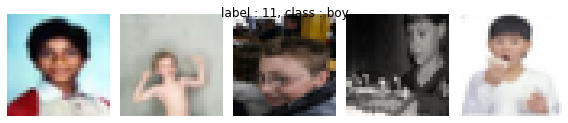

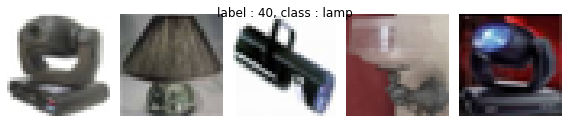

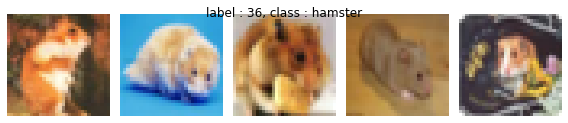

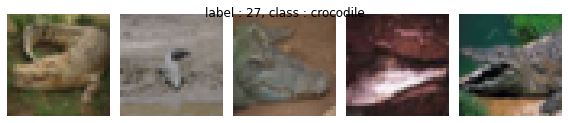

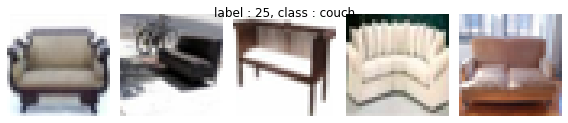

In [ ]:
class_plotted = np.random.choice(range(n_classes), 5, replace = False)
for i in range(len(class_plotted)):
    image_samples = X[y.reshape(-1) == class_plotted[i]][:5]
    fig, ax = plt.subplots(nrows = 1, ncols = 5,figsize = (8,8))
    fig.suptitle("label : %d, class : %s" % (class_plotted[i], fine_label_list[class_plotted[i]]), y = .6)
    for j in range(5):
        ax[j].imshow(image_samples[j])
        ax[j].axis('off')  
    fig.tight_layout()
plt.show()

In [9]:
# Spliting the training data into a training data and a validation data.
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(X, y):
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
    
print("The number of training data : ", X_train.shape[0])
print("The number of validation data : ", X_val.shape[0])

del X, y

The number of training data :  40000
The number of validation data :  10000


In [12]:
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)
class DataGenerator(keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # =========================================================== #
        # Generate mini-batch of X
        # =========================================================== #
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img
            
        
        # =========================================================== #
        # Generate mini-batch of y
        # =========================================================== #
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])
        
        return composition(image = img)['image']
        
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
            
        return img_batch

In [13]:
train_generator = DataGenerator(X_train, y_train, augment = True)
valid_generator = DataGenerator(X_val, y_val, augment = False)

In [ ]:
resnet_model = keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

model = Sequential([
        resnet_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(n_classes, activation='softmax')                   
])
model.summary()

219062272/219055592 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               786944    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 100)               51300     
Total params: 55,177,028
Trainable params: 55,115,460

In [ ]:
# don't run
efnb0.trainable = False

In [ ]:
#save_dir = 'Save_model/'
model_name = 'Resnet_cw1_sample.h5'
#if not os.path.isdir(save_dir):
#    os.makedirs(save_dir)
filepath = os.path.join('/content/drive/MyDrive/', model_name)

sgd = SGD(learning_rate = lr, momentum = 0.9, nesterov = True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
callbacks = [es, rlrop, checkpoint]

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])

In [ ]:
hist = model.fit_generator(train_generator, validation_data = valid_generator, 
                           epochs = epochs, verbose = 1, callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
1250/1250 [==============================] - 1597s 1s/step - loss: 2.1899 - acc: 0.4648 - val_loss: 0.9792 - val_acc: 0.7449

Epoch 00001: val_acc improved from -inf to 0.74489, saving model to /content/drive/MyDrive/Resnet_cw1_sample.h5
Epoch 2/25
1250/1250 [==============================] - 1552s 1s/step - loss: 1.1395 - acc: 0.6805 - val_loss: 0.6825 - val_acc: 0.7994

Epoch 00002: val_acc improved from 0.74489 to 0.79938, saving model to /content/drive/MyDrive/Resnet_cw1_sample.h5
Epoch 3/25
1250/1250 [==============================] - 1554s 1s/step - loss: 0.8906 - acc: 0.7442 - val_loss: 0.6209 - val_acc: 0.8195

Epoch 00003: val_acc improved from 0.79938 to 0.81951, saving model to /content/drive/MyDrive/Resnet_cw1_sample.h5
Epoch 4/25
1250/1250 [==============================] - 1553s 1s/step - loss: 0.7399 - acc: 0.7847 - val_loss: 0.6030 - val_acc: 0.8256

Epoch 00004: val_acc improved from 0.81951 to 0.82562, saving model to /content/drive/MyDrive/Resnet_cw1_sampl

KeyboardInterrupt: ignored

In [6]:
model = load_model('/content/drive/MyDrive/coursework1/Resnet_cw1_sample.h5')

In [ ]:
hist = model.fit_generator(train_generator, validation_data = valid_generator, 
                           epochs = epochs, verbose = 1, callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/16
1250/1250 [==============================] - 3193s 3s/step - loss: 0.1387 - acc: 0.9596 - val_loss: 0.5378 - val_acc: 0.8579

Epoch 00001: val_acc did not improve from 0.85797
Epoch 2/16
1250/1250 [==============================] - 3198s 3s/step - loss: 0.1385 - acc: 0.9599 - val_loss: 0.5409 - val_acc: 0.8581

Epoch 00002: val_acc improved from 0.85797 to 0.85807, saving model to /content/drive/MyDrive/Resnet_cw1_sample.h5
Epoch 3/16
 858/1250 [===================>..........] - ETA: 15:33 - loss: 0.1366 - acc: 0.9606

KeyboardInterrupt: ignored

In [14]:
# augment = False, shuffle = False.
test_generator = DataGenerator(X_test, mode = 'predict', batch_size = 8, augment = False, shuffle = False)
y_pred = model.predict_generator(test_generator,verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)

print("The accuracy on the testing data : {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1250/1250 [==============================] - 148s 92ms/step
The accuracy on the testing data : 85.17%


In [29]:
# augment = False, shuffle = False.
test_generator = DataGenerator(X_val, mode = 'predict', batch_size = 8, augment = False, shuffle = False)
y_pred = model.predict_generator(test_generator,verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)

print("The accuracy on the testing data : {:.2f}%".format(100 * accuracy_score(y_val, y_pred)))

The accuracy on the testing data : 85.80%
